In [4]:
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from glob import glob

from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [5]:
def load_data_from_zip(zip_path):
    """
    Load chest X-ray images from a zip file, handling various directory structures.
    
    Parameters:
    -----------
    zip_path : str
        Path to the zip file containing image data
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths within the zip
    """
    import zipfile
    import os
    import numpy as np
    from skimage import io
    from io import BytesIO
    
    images = []
    labels = []
    image_paths = []
    
    # These are the expected class names based on your description
    expected_classes = ["COVID-19", "Normal", "Pneumonia"]
    
    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get all file names in the zip
        file_list = zip_ref.namelist()
        
        # Analyze the directory structure
        directories = {}
        for path in file_list:
            parts = path.split('/')
            # Skip empty parts or files directly in root
            if len(parts) > 1 and parts[0]:
                if parts[0] not in directories:
                    directories[parts[0]] = []
                if len(parts) > 2 and parts[1]:
                    directories[parts[0]].append(parts[1])
        
        # Identify if we have a nested structure or direct class folders
        class_folders = []
        prefix_path = ""
        
        # Check if any of the top directories are the expected classes
        top_level_matches = [d for d in directories.keys() if any(
            cls.lower() in d.lower() for cls in expected_classes)]
        
        if top_level_matches:
            # The classes are at the top level
            class_folders = sorted(list(set(directories.keys())))
            print(f"Found classes at the top level: {class_folders}")
        else:
            # Try to find the classes in subdirectories
            for top_dir, subdirs in directories.items():
                cleaned_subdirs = list(set([s for s in subdirs if s and not s.startswith('.')]))
                matches = [d for d in cleaned_subdirs if any(
                    cls.lower() in d.lower() for cls in expected_classes)]
                
                if matches:
                    class_folders = sorted(list(set(cleaned_subdirs)))
                    prefix_path = top_dir + "/"
                    print(f"Found classes in subdirectory '{top_dir}': {class_folders}")
                    break
        
        if not class_folders:
            raise ValueError("Could not identify class folders in the zip structure")
        
        # Create a label mapping
        label_map = {i: label for i, label in enumerate(class_folders)}
        
        # Loop through each class folder
        for label_idx, folder in enumerate(class_folders):
            print(f"Loading images from {folder}...")
            folder_path = f"{prefix_path}{folder}/"
            
            # Get all image files in this folder
            img_paths = [f for f in file_list if f.startswith(folder_path) and 
                        (f.lower().endswith('.png') or f.lower().endswith('.jpg') or 
                         f.lower().endswith('.jpeg')) and not '/.' in f]
            
            # Load each image
            loaded_count = 0
            for img_path in img_paths:
                try:
                    # Read image data from zip
                    with zip_ref.open(img_path) as file:
                        img_data = BytesIO(file.read())
                        img = io.imread(img_data)
                        
                        # Convert to grayscale if it's color
                        if len(img.shape) > 2:
                            img = np.mean(img, axis=2).astype(np.uint8)
                        
                        images.append(img)
                        labels.append(label_idx)
                        image_paths.append(img_path)
                        loaded_count += 1
                        
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
            
            print(f"Loaded {loaded_count} images from {folder}")
        
        print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [6]:
# cleaned image data
cleaned_path = os.path.join(os.getcwd(), 'cleaned.zip')
cl_images, cl_labels, cl_label_map, cl_image_paths = load_data_from_zip(cleaned_path)

Found classes in subdirectory 'cleaned': ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


In [7]:
# uncleaned images
data_dir = os.path.join(os.getcwd(), "Xray_data.zip")
images, labels, label_map, image_paths = load_data_from_zip(data_dir)


Found classes in subdirectory 'Xray_data': ['COVID-19', 'Normal ', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal ...
Loaded 234 images from Normal 
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


In [10]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2,3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Parameters:
    -----------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    image_paths : list
        List of image file paths or IDs
    target_size : tuple
        Size to resize all images to (width, height)
    distances : list
        List of distances for GLCM calculation
    angles : list
        List of angles for GLCM calculation
    g_levels : int
        Number of gray levels to use for GLCM calculation (default is 256)

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing image_id, label, and all GLCM features
    """
    import pandas as pd
    import numpy as np
    from skimage.feature import graycomatrix, graycoprops
    from skimage.transform import resize
    import os
    
    # GLCM properties to calculate
    properties = ['contrast', 'homogeneity', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

Extracted glcm features('contrast', 'homogeneity', 'energy', and 'correlation') using distances [1,5] and angles [0, pi/2] (aka above and lateral) from the unedited x ray images.

In [11]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1,5],
    angles=[0, np.pi/2]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


In [12]:
glcm_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a90,contrast_d5_a0,contrast_d5_a90,homogeneity_d1_a0,homogeneity_d1_a90,homogeneity_d5_a0,homogeneity_d5_a90,energy_d1_a0,energy_d1_a90,energy_d5_a0,energy_d5_a90,correlation_d1_a0,correlation_d1_a90,correlation_d5_a0,correlation_d5_a90
0,radiopaedia-2019-novel-coronavirus-infected-pn...,0,24.453844,24.176630,226.847591,177.311637,0.370738,0.395188,0.217560,0.260809,0.096179,0.097185,0.084514,0.089820,0.997345,0.997376,0.975167,0.980610
1,9fdd3c3032296fd04d2cad5d9070d4_jumbo,0,11.199746,11.994970,88.008013,78.651620,0.419133,0.417754,0.233933,0.269378,0.044930,0.044160,0.034020,0.034414,0.997881,0.997723,0.983295,0.984810
2,16669_3_1,0,38.821379,28.421623,105.586666,120.031816,0.441676,0.460867,0.245330,0.242679,0.031590,0.032510,0.020713,0.020742,0.987164,0.990556,0.965078,0.959352
3,radiol.2020201160.fig6b,0,49.370096,31.732915,262.576950,248.636696,0.397068,0.431660,0.168192,0.216623,0.027371,0.028953,0.017167,0.018613,0.992311,0.995055,0.959290,0.961091
4,16663_1_1,0,23.052864,14.995031,265.784821,124.553809,0.363245,0.403813,0.158876,0.204399,0.040099,0.041171,0.032132,0.032723,0.996277,0.997577,0.956411,0.979611


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=glcm_df['label']
                                                    )

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest on unedited data

In [15]:
# Train a Random Forest Classifier on scaled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=113)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.86      0.96      0.91        70
           2       0.85      0.78      0.81        45

    accuracy                           0.88       181
   macro avg       0.88      0.87      0.87       181
weighted avg       0.88      0.88      0.88       181


Confusion Matrix:


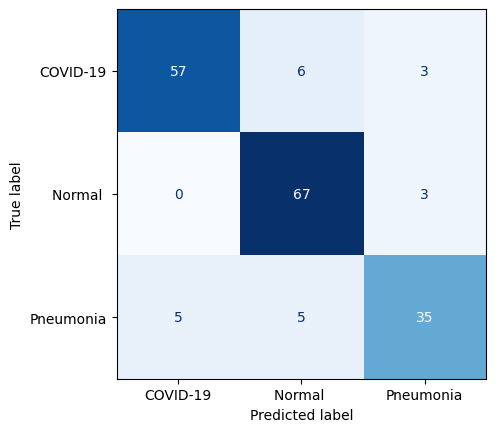

In [16]:
# Evaluate the model

y_pred = rf_model.predict(X_test_scaled)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# SVM on unedited data

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters rbf: {grid_search.best_params_}")

Best parameters rbf: {'C': 100, 'gamma': 0.01}



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        66
           1       0.92      0.84      0.88        70
           2       0.78      0.84      0.81        45

    accuracy                           0.87       181
   macro avg       0.86      0.87      0.86       181
weighted avg       0.87      0.87      0.87       181


Confusion Matrix:


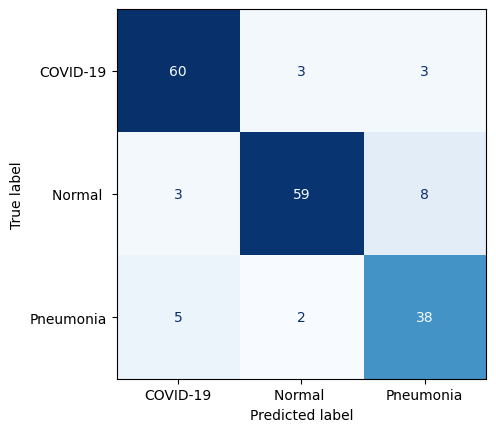

In [18]:
svm_rbf = SVC(kernel='rbf',
              C=100,
              gamma=0.01,
              class_weight='balanced',
              random_state=113
              )
svm_rbf.fit(X_train_scaled, y_train)

           
# Evaluate
y_pred = svm_rbf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()


In [19]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters linear: {grid_search.best_params_}")

Best parameters linear: {'C': 100, 'gamma': 'scale'}



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        66
           1       0.88      0.80      0.84        70
           2       0.75      0.84      0.79        45

    accuracy                           0.85       181
   macro avg       0.84      0.85      0.85       181
weighted avg       0.86      0.85      0.85       181


Confusion Matrix:


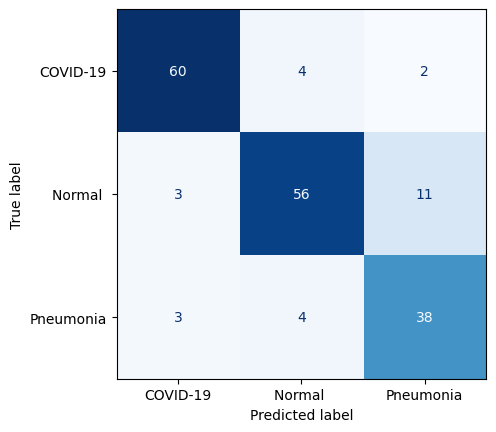

In [20]:
svm_linear = SVC(kernel='linear',
                 C=100,
                 gamma='scale',
                class_weight='balanced',
                random_state=113
                )
svm_linear.fit(X_train_scaled, y_train)

y_pred = svm_linear.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)

# Cleaned Data

In [21]:
cl_glcm, cl_glcm_df = extract_glcm_features_df(
    cl_images, 
    cl_labels, 
    cl_image_paths, 
    target_size=(512, 512),
    distances=[1,5],
    angles=[0, np.pi/2]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    cl_glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    cl_glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=cl_glcm_df['label']
                                                    )

# Standardize the features
scaler = StandardScaler()
cl_X_train_scaled = scaler.fit_transform(X_train)
cl_X_test_scaled = scaler.transform(X_test)

# Random Forest on Cleaned Data

In [23]:
# Train a Random Forest Classifier on scaled cleaned data
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(cl_X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=113)


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        66
           1       0.81      0.86      0.83        70
           2       0.76      0.64      0.70        45

    accuracy                           0.82       181
   macro avg       0.81      0.80      0.81       181
weighted avg       0.82      0.82      0.82       181


Confusion Matrix:


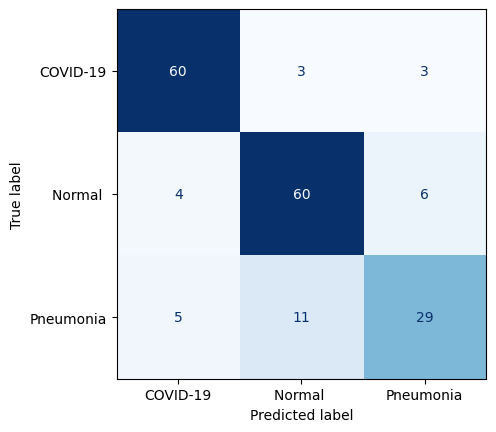

In [25]:
# Evaluate the model

y_pred = rf_model.predict(cl_X_test_scaled)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()